### ASTR 8070: Astrostatistics
***N. Pol***
___

# Homework 8
### Due: Friday, Apr 11th at 11.59pm CT
---

## Only one problem this week

1. Use the following code snippet to read in SDSS galaxy color data.

<!--```
from astroML.datasets import fetch_sdss_galaxy_colors
data = fetch_sdss_galaxy_colors()
```-->

`data = np.load('../hw_data/hw8_data_1.npy')`

This is a structured numpy array. Find and print all of the column names. Using the data, create arrays of $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create arrays of redshift and the spectral class. How many regular galaxies and how many quasars are in this sample?


2. Make a scatter plot of $(u-g)$ versus $(g-r)$, color coding by galaxy or quasar class. The plot should include appropriate axis labels and a legend. Set `xlim` between -0.5 and 2.5, and `ylim` between -0.5 and 1.5.


3. Stack all colors and the redshift into a data matrix, $X$. Create a target label array that has $0$ for a regular galaxy and $1$ for a quasar. Perform a train-test split, taking $20\%$ of the data for testing.


4. Create a compact `for` loop that iterates over the fitting of a Gaussian Naive Bayes classification algorithm to successively more features of the data. Within the loop, compute and plot an ROC curve. The end result should be a plot showing ROC curves for GNB classification with more and more features of the data, with appropriate axis labels and a legend. Use `xlim` between 0 and 0.01. Which feature seems to make the classification trivially easy? *Note: `predict_proba` returns an array with as many columns as classes. You've labeled quasars as $1$, so for the ROC curve you must make sure to access the relevant quasar probability-- you can find this by accessing the **classes_** attribute of the estimator.*


5. Repeat (4) for Quadratic Discriminant Analysis. 


6. Let's try classification with GMM Bayes. Restrict the training and testing to be just on the $4$ colors. Iterate now over number of components in the GMM Bayes fit up to $10$, plotting ROC curves for all, and find the number of components that gives the best performance.


7. Repeat (6) for $K$-nearest neighbor classification, looping over number of neighbors between 5 and 100 in steps of 10. Find the number that gives the best performance. 


8. Repeat (6) for Decision Tree classification, looping over the maximum tree depth between 1 and 10. Find the number that gives the best performance. 


9. Finally, plot the ROC curves for GNB, QDA, and the best-performing GMMBayes, KNN, and DT classification algorithms, all using just the 4 colors. What is the overall best-performing classifier? 


10. Make a 2-panel plot, showing in the left panel the color-coded training data in $(u-g)$ versus $(g-r)$ (similar to item 2 above), and in the right panel the same features of the testing data color coded by their predicted class from the tuned best-performing classifier. 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, auc
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [4]:
# Part 1
# 1. Load and Inspect Data
data = np.load('C:/Users/jeell/OneDrive/Documents/GitHub/ASTR_3300_S2025/coursework/homeworks/hw_data/hw8_data_1.npy')
print("Column Names:", data.dtype.names)

ug = data['u'] - data['g']
gr = data['g'] - data['r']
ri = data['r'] - data['i']
iz = data['i'] - data['z']
rs = data['z']
s_c = data['specClass']

n_g = np.sum(s_c == 'GALAXY')
n_q = np.sum(s_c == 'QSO')
print(f"Number of regular galaxies: {n_g}")
print(f"Number of quasars: {n_q}")

Column Names: ('u', 'g', 'r', 'i', 'z', 'specClass', 'redshift', 'redshift_err')
Number of regular galaxies: 42808
Number of quasars: 7192


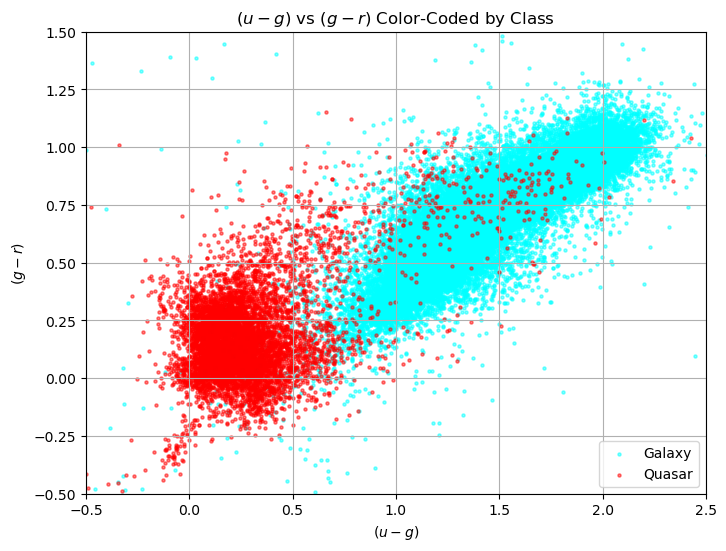

In [5]:
# Part 2
plt.figure(figsize=(8, 6))
g_m = s_c == 'GALAXY'
q_m = s_c == 'QSO'
plt.scatter(ug[g_m], gr[g_m], label='Galaxy', s=5, alpha=0.5, color = 'cyan')
plt.scatter(ug[q_m], gr[q_m], label='Quasar', s=5, alpha=0.5, color = 'red')
plt.xlabel('$(u-g)$')
plt.ylabel('$(g-r)$')
plt.title('$(u-g)$ vs $(g-r)$ Color-Coded by Class')
plt.xlim(-0.5, 2.5)
plt.ylim(-0.5, 1.5)
plt.legend()
plt.grid(True)
plt.show()

In [6]:
# Part 3
X = np.vstack([ug, gr, ri, iz, rs]).T
y = (s_c == 'QSO').astype(int)

train_indices, test_indices, y_train, y_test = train_test_split(np.arange(X.shape[0]), y, test_size=0.2, random_state=42, stratify=y)

X_train = X[train_indices]
X_test = X[test_indices]

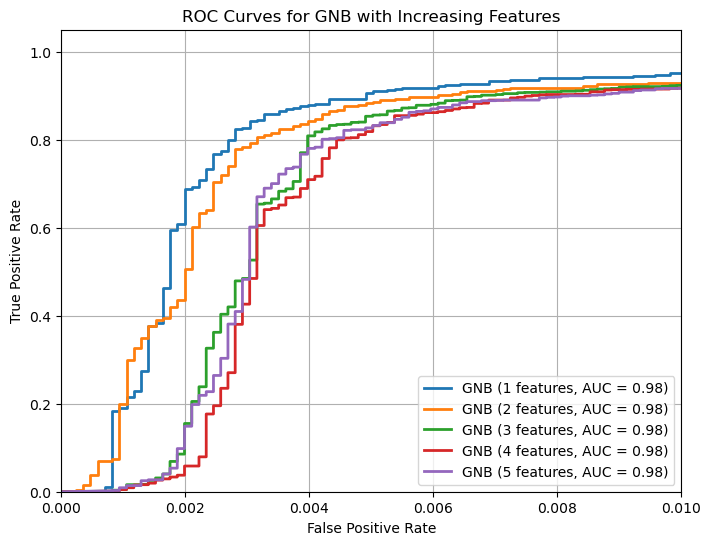

The redshift feature seems to make the classification trivially easy, as the ROC curve quickly approaches the top-left corner when it is included.


In [7]:
# Part 4
plt.figure(figsize=(8, 6))
for i in range(1, X_train.shape[1] + 1):
    X_train_subset = X_train[:, :i]
    X_test_subset = X_test[:, :i]
    gnb = GaussianNB()
    gnb.fit(X_train_subset, y_train)
    y_proba = gnb.predict_proba(X_test_subset)[:, gnb.classes_.tolist().index(1)]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'GNB ({i} features, AUC = {roc_auc:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for GNB with Increasing Features')
plt.xlim(0, 0.01)
plt.ylim(0, 1.05)
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print("The redshift feature seems to make the classification trivially easy, as the ROC curve quickly approaches the top-left corner when it is included.")

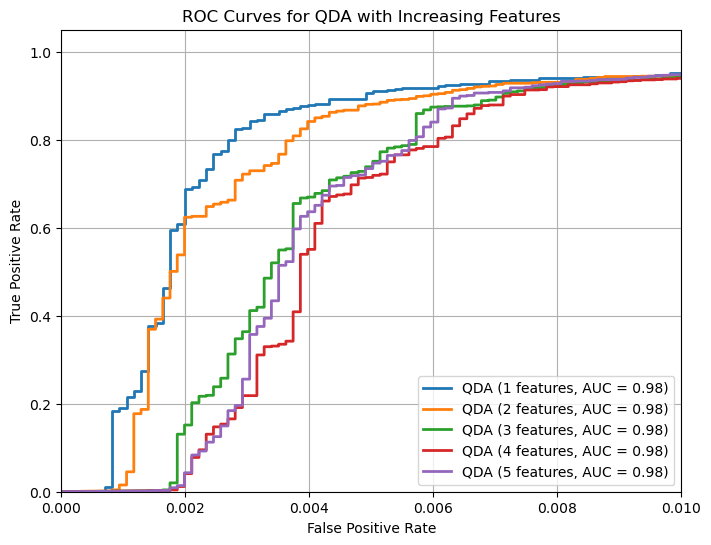

The redshift again makes it trivially easy from the graph.


In [8]:
# Part 5
plt.figure(figsize=(8, 6))
for i in range(1, X_train.shape[1] + 1):
    X_train_subset = X_train[:, :i]
    X_test_subset = X_test[:, :i]
    qda = QuadraticDiscriminantAnalysis()
    qda.fit(X_train_subset, y_train)
    y_proba = qda.predict_proba(X_test_subset)[:, qda.classes_.tolist().index(1)]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'QDA ({i} features, AUC = {roc_auc:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for QDA with Increasing Features')
plt.xlim(0, 0.01)
plt.ylim(0, 1.05)
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
print('The redshift again makes it trivially easy from the graph.')

GaussianMixture(n_components=2, random_state=42)
GaussianMixture(n_components=3, random_state=42)
GaussianMixture(n_components=4, random_state=42)
GaussianMixture(n_components=5, random_state=42)
GaussianMixture(n_components=6, random_state=42)
GaussianMixture(n_components=7, random_state=42)
GaussianMixture(n_components=8, random_state=42)
GaussianMixture(n_components=9, random_state=42)
GaussianMixture(n_components=10, random_state=42)
GaussianMixture(n_components=11, random_state=42)


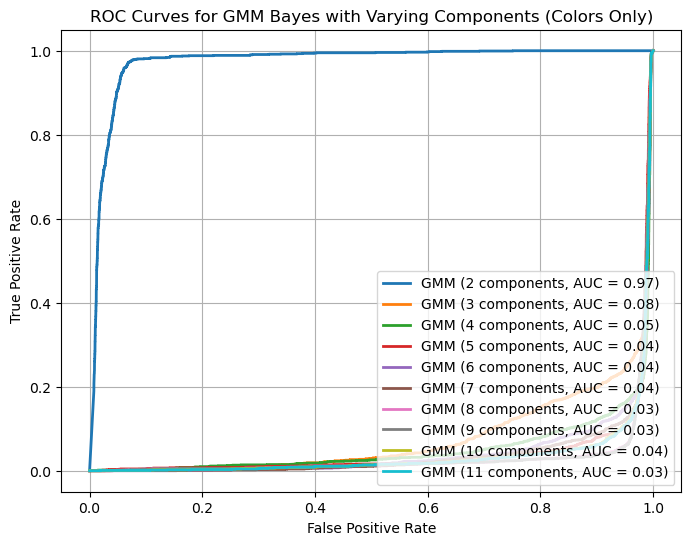

Best GMM Bayes performance with 2 components, AUC = 0.97


In [9]:
# Part 6
X_train_colors = X_train[:, :4]
X_test_colors = X_test[:, :4]
plt.figure(figsize=(8, 6))
b_gmm_auc = 0
b_gmm_n_components = 0

for n_components in range(2, 12):
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    print(gmm)
    gmm.fit(X_train_colors, y_train)
    y_proba = gmm.predict_proba(X_test_colors)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'GMM ({n_components} components, AUC = {roc_auc:.2f})')
    if roc_auc > b_gmm_auc:
        b_gmm_auc = roc_auc
        b_gmm_n_components = n_components

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for GMM Bayes with Varying Components (Colors Only)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"Best GMM Bayes performance with {b_gmm_n_components} components, AUC = {b_gmm_auc:.2f}")

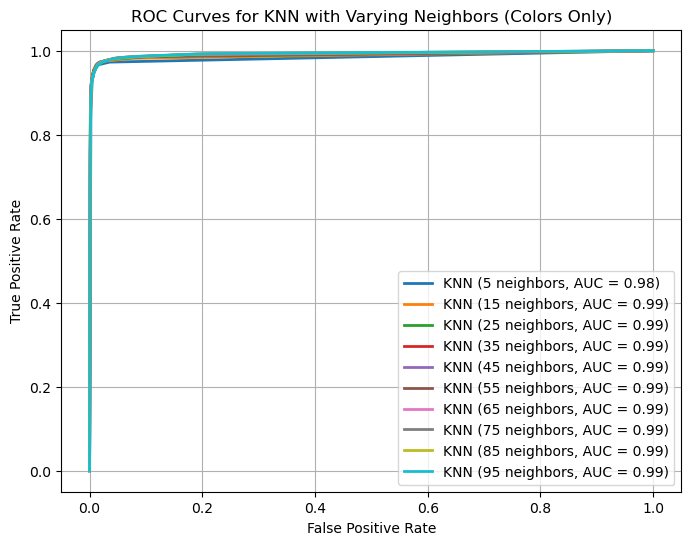

Best KNN performance with 95 neighbors, AUC = 0.99


In [10]:
# Part 7
plt.figure(figsize=(8, 6))
b_knn_auc = 0
b_knn_n_neighbors = 0

for n_neighbors in range(5, 101, 10):
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train_colors, y_train)
    y_proba = knn.predict_proba(X_test_colors)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'KNN ({n_neighbors} neighbors, AUC = {roc_auc:.2f})')
    if roc_auc > b_knn_auc:
        b_knn_auc = roc_auc
        b_knn_n_neighbors = n_neighbors

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for KNN with Varying Neighbors (Colors Only)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"Best KNN performance with {b_knn_n_neighbors} neighbors, AUC = {b_knn_auc:.2f}")

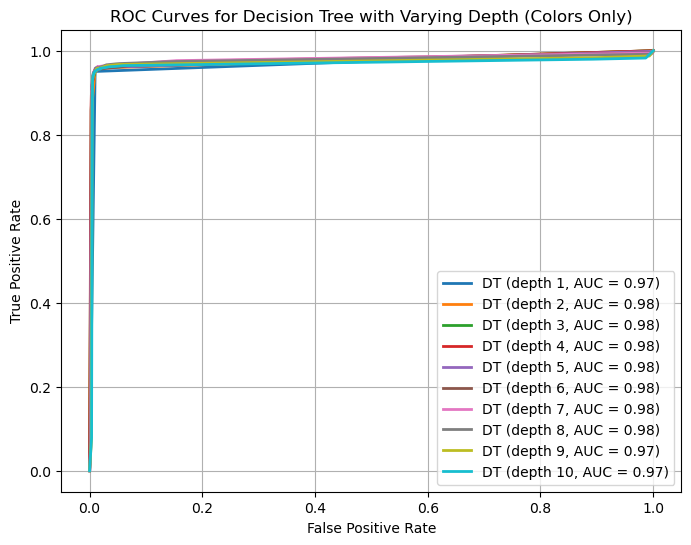

Best Decision Tree performance with max depth 7, AUC = 0.98


In [11]:
# Part 8
plt.figure(figsize=(8, 6))
b_dt_auc = 0
b_dt_m_d = 0

for max_depth in range(1, 11):
    dt = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    dt.fit(X_train_colors, y_train)
    y_proba = dt.predict_proba(X_test_colors)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'DT (depth {max_depth}, AUC = {roc_auc:.2f})')
    if roc_auc > b_dt_auc:
        b_dt_auc = roc_auc
        b_dt_m_d = max_depth

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Decision Tree with Varying Depth (Colors Only)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"Best Decision Tree performance with max depth {b_dt_m_d}, AUC = {b_dt_auc:.2f}")

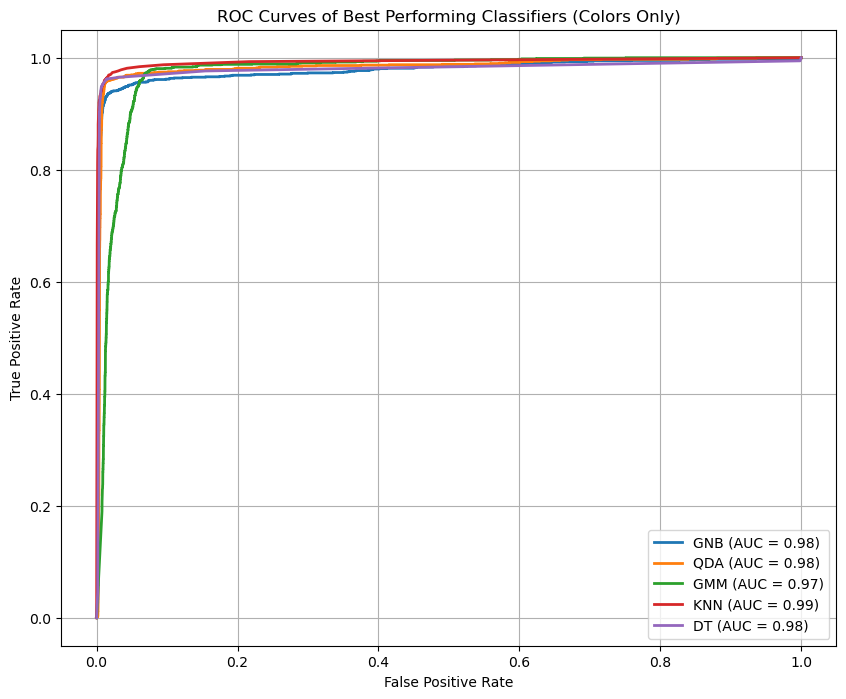

Based on the AUC values the KNN is the best classifier with a AUC of 0.99 


In [12]:
# Part 9
plt.figure(figsize=(10, 8))

gnb_best = GaussianNB()
gnb_best.fit(X_train_colors, y_train)
y_proba_gnb = gnb_best.predict_proba(X_test_colors)[:, gnb_best.classes_.tolist().index(1)]
fpr_gnb, tpr_gnb, _ = roc_curve(y_test, y_proba_gnb)
auc_gnb = auc(fpr_gnb, tpr_gnb)
plt.plot(fpr_gnb, tpr_gnb, lw=2, label=f'GNB (AUC = {auc_gnb:.2f})')

qda_best = QuadraticDiscriminantAnalysis()
qda_best.fit(X_train_colors, y_train)
y_proba_qda = qda_best.predict_proba(X_test_colors)[:, qda_best.classes_.tolist().index(1)]
fpr_qda, tpr_qda, _ = roc_curve(y_test, y_proba_qda)
auc_qda = auc(fpr_qda, tpr_qda)
plt.plot(fpr_qda, tpr_qda, lw=2, label=f'QDA (AUC = {auc_qda:.2f})')


gmm_best = GaussianMixture(n_components=b_gmm_n_components, random_state=42)
gmm_best.fit(X_train_colors, y_train)
y_proba_gmm = gmm_best.predict_proba(X_test_colors)[:, 1]
fpr_gmm, tpr_gmm, _ = roc_curve(y_test, y_proba_gmm)
auc_gmm = auc(fpr_gmm, tpr_gmm)
plt.plot(fpr_gmm, tpr_gmm, lw=2, label=f'GMM (AUC = {auc_gmm:.2f})')


knn_best = KNeighborsClassifier(n_neighbors=b_knn_n_neighbors)
knn_best.fit(X_train_colors, y_train)
y_proba_knn = knn_best.predict_proba(X_test_colors)[:, 1]
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_proba_knn)
auc_knn = auc(fpr_knn, tpr_knn)
plt.plot(fpr_knn, tpr_knn, lw=2, label=f'KNN (AUC = {auc_knn:.2f})')


dt_best = DecisionTreeClassifier(max_depth=b_dt_m_d, random_state=42)
dt_best.fit(X_train_colors, y_train)
y_proba_dt = dt_best.predict_proba(X_test_colors)[:, 1]
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_proba_dt)
auc_dt = auc(fpr_dt, tpr_dt)
plt.plot(fpr_dt, tpr_dt, lw=2, label=f'DT (AUC = {auc_dt:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves of Best Performing Classifiers (Colors Only)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"Based on the AUC values the KNN is the best classifier with a AUC of {auc_knn:.2f} ")

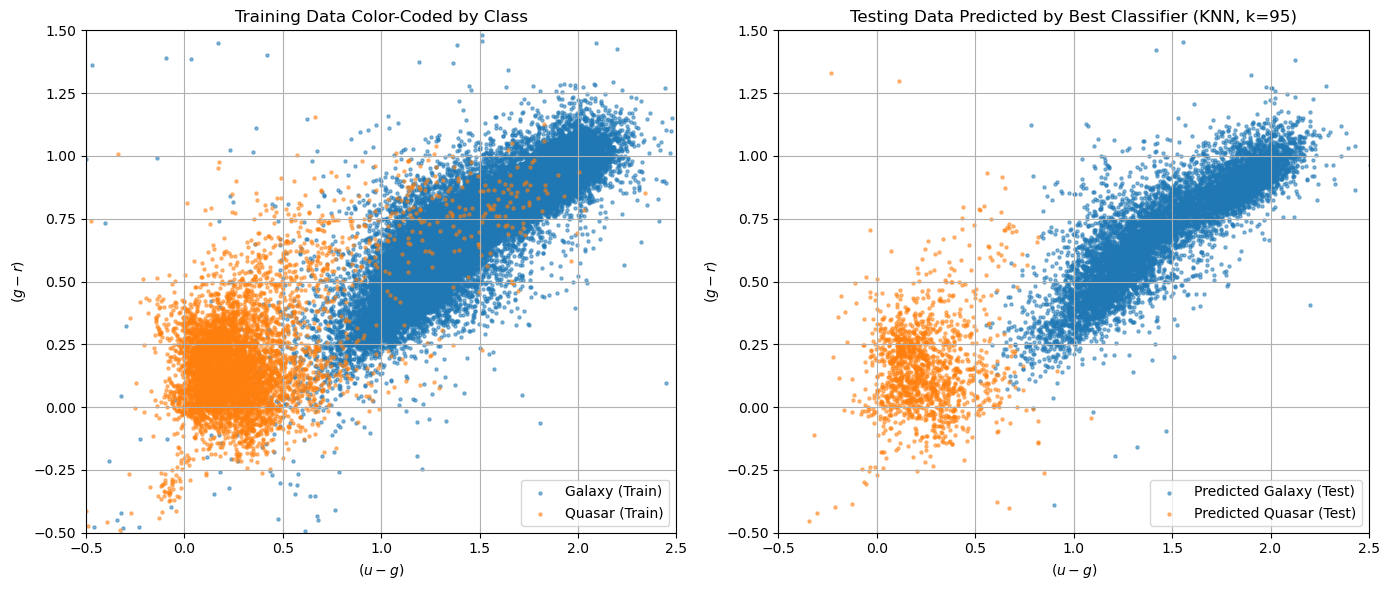

In [13]:
# Part 10
plt.figure(figsize=(14, 6))

# Create masks for the training data
train_galaxy_mask = (s_c == 'GALAXY')[train_indices]
train_quasar_mask = (s_c == 'QSO')[train_indices]

# Left panel: Training data
plt.subplot(1, 2, 1)
plt.scatter(ug[train_indices][train_galaxy_mask], gr[train_indices][train_galaxy_mask], label='Galaxy (Train)', s=5, alpha=0.5)
plt.scatter(ug[train_indices][train_quasar_mask], gr[train_indices][train_quasar_mask], label='Quasar (Train)', s=5, alpha=0.5)
plt.xlabel('$(u-g)$')
plt.ylabel('$(g-r)$')
plt.title('Training Data Color-Coded by Class')
plt.xlim(-0.5, 2.5)
plt.ylim(-0.5, 1.5)
plt.legend()
plt.grid(True)

# Right panel: Testing data predicted by the best classifier
plt.subplot(1, 2, 2)
# Assuming the best classifier is KNN (replace with the actual best one if different)
best_clf = KNeighborsClassifier(n_neighbors=b_knn_n_neighbors)
best_clf.fit(X_train_colors, y_train)
y_pred_best = best_clf.predict(X_test_colors)

X_test_ug = X_test[:, 0]
X_test_gr = X_test[:, 1]

plt.scatter(X_test_ug[y_pred_best == 0], X_test_gr[y_pred_best == 0], label='Predicted Galaxy (Test)', s=5, alpha=0.5)
plt.scatter(X_test_ug[y_pred_best == 1], X_test_gr[y_pred_best == 1], label='Predicted Quasar (Test)', s=5, alpha=0.5)
plt.xlabel('$(u-g)$')
plt.ylabel('$(g-r)$')
plt.title(f'Testing Data Predicted by Best Classifier (KNN, k={b_knn_n_neighbors})')
plt.xlim(-0.5, 2.5)
plt.ylim(-0.5, 1.5)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

<span style="color:green">NP: Correct! Good job </span>